<a href="https://colab.research.google.com/github/rafisondi/ml-playground/blob/main/GP_HyperparameterTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gaussian Process hyperparamter tuning
  

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import seaborn as sns
import scipy.spatial

# Set matplotlib and seaborn plotting style
sns.set_style('darkgrid')
np.random.seed(42)


In [96]:
def exponentiated_quadratic(xa, xb, sigma = 1.0, lenght = 1.0):
    sq_norm = -0.5 * scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean')
    return sigma**2 * np.exp(sq_norm / lenght**2)

def GaussianProcess(mu_prior, X, X_new ,y, theta = (1 ,1), var_noise = 0.0, ):
  sigma11 = exponentiated_quadratic(X, X, theta[0], theta[1]) + var_noise * np.eye(len(X))
  sigma12 = exponentiated_quadratic(X, X_new, theta[0], theta[1])
  sigma22 = exponentiated_quadratic(X_new, X_new, theta[0], theta[1])
  mu_post = sigma12.T @ np.linalg.inv(sigma11) @ (y - mu_prior)
  sigma_post = sigma22 - sigma12.T @ np.linalg.inv(sigma11) @ sigma12
  return mu_post, sigma_post

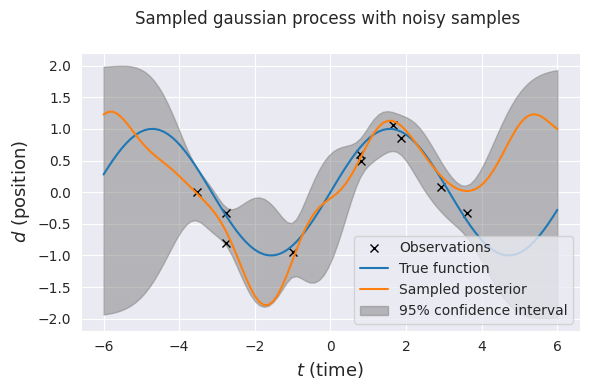

In [97]:
# Posterior calculation based on sampled realization of a function f
samples_from_gp = 50
X = np.expand_dims(np.linspace(-4, 4, samples_from_gp), 1)
f_sin = lambda x: (np.sin(x)).flatten()

n1 = 10 # number of observation of function f
var_noise = 0.05
domain = (-6, 6)

# Sample observations (X1, y1) on the function
X1 = np.random.uniform(domain[0]+2, domain[1]-2, size=(n1, 1))
y1 = f_sin(X1) + np.random.normal(0, np.sqrt(var_noise), size=(n1, 1)).flatten()

n_inference = 100
X2 = np.linspace(*domain, n_inference).reshape(-1, 1)

# Gaussian Process posterior
mu_post, sigma_post = GaussianProcess(np.zeros(n1), X1, X2, y1, var_noise = var_noise)
ys = np.random.multivariate_normal(
    mean=mu_post, cov=sigma_post)

# Covariance of each point
diag = np.diag(sigma_post)
std_dev = np.sqrt(diag)
confidence_interval = 1.96 * std_dev

# Plot the results
plt.figure(figsize=(6, 4))
plt.plot(X1, y1, 'kx', label='Observations')
plt.plot(np.linspace(*domain, 100), f_sin(np.linspace(*domain, 100)),
         label='True function')
plt.plot(X2, ys, label='Sampled posterior')
plt.title((
    'Sampled gaussian process with noisy samples \n '))
plt.fill_between(X2.flatten(),
                 (mu_post - confidence_interval),
                 (mu_post + confidence_interval),
                 color='gray', alpha=0.5, label='95% confidence interval')

plt.xlabel('$t$ (time)', fontsize=13)
plt.ylabel('$d$ (position)', fontsize=13)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Optimized length scale: 1.3174709112105194
Optimized signal variance: 0.6694110797197861


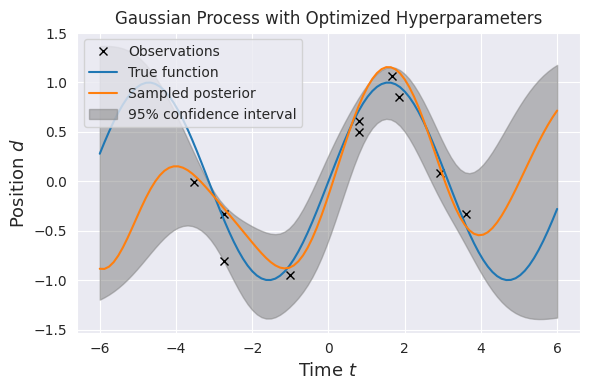

In [104]:
## Maximum likelihood estimation of hyperparameters
from scipy.optimize import minimize

def objective_function(x, y, var_noise):
    def nll_function(theta):
        # Kernel with added noise term
        kernel = exponentiated_quadratic(x, x, theta[0], theta[1]) + (np.sqrt(var_noise) ** 2) * np.eye(len(x))
        # Negative log likelihood for GP
        return 0.5 * np.log(np.linalg.det(kernel)) + \
               0.5 * y.dot(np.linalg.inv(kernel).dot(y)) + \
               0.5 * len(x) * np.log(2 * np.pi)
    return nll_function

# Optimize hyperparameters
initial_guess = [1, 1]
bounds = [(1e-5, None), (1e-5, None)]
res = minimize(objective_function(X1, y1, var_noise), initial_guess, bounds=bounds, method='L-BFGS-B')
sigma_f_opt, l_opt  = res.x
print("Optimized length scale:", l_opt)
print("Optimized signal variance:", sigma_f_opt)

# Compute posterior mean and covariance with optimized kernel parameters
mu_post_opt, sigma_post_opt = GaussianProcess(
    np.zeros(n1), X1, X2, y1, theta=[sigma_f_opt, l_opt], var_noise=var_noise
)
confidence_interval_opt = 1.96 * np.sqrt(np.diag(sigma_post_opt))

plt.figure(figsize=(6, 4))
plt.plot(X1, y1, 'kx', label='Observations')
plt.plot(np.linspace(*domain, 100), f_sin(np.linspace(*domain, 100)), label='True function')
plt.plot(X2, ys_opt, label='Sampled posterior')
plt.fill_between(
    X2.flatten(),
    (mu_post_opt - confidence_interval_opt),
    (mu_post_opt + confidence_interval_opt),
    color='gray', alpha=0.5, label='95% confidence interval'
)
plt.title('Gaussian Process with Optimized Hyperparameters')
plt.xlabel('Time $t$', fontsize=13)
plt.ylabel('Position $d$', fontsize=13)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Optimized kernel parameters: l = 1.3174782396906985, sigma_f = 0.6694105300298999
Difference in optimized kernel parameters: l_diff = -7.328480179147334e-06, sigma_diff = 5.496898861645505e-07


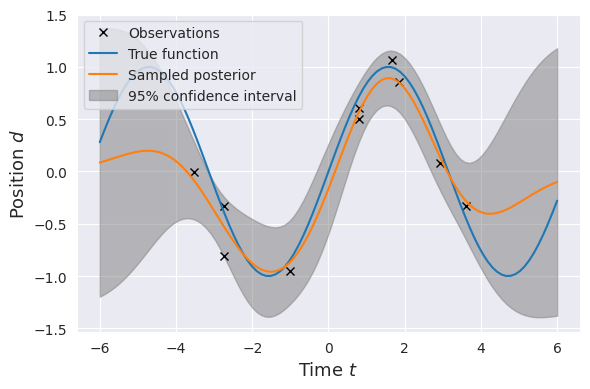

In [108]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
import numpy as np
import matplotlib.pyplot as plt

# Define the noise and kernel
rbf = ConstantKernel(1.0) * RBF(length_scale=1.0)
gpr = GaussianProcessRegressor(kernel=rbf, alpha=np.sqrt(var_noise) **2)

# Fit the Gaussian Process model
gpr.fit(X1, y1)
mu_s, cov_s = gpr.predict(X2, return_cov=True)
confidence_interval_s = 1.96 * np.sqrt(np.diag(cov_s))
l = gpr.kernel_.k2.get_params()['length_scale']
sigma_f = np.sqrt(gpr.kernel_.k1.get_params()['constant_value'])

#Evaluation
print(f'Optimized kernel parameters: l = {l}, sigma_f = {sigma_f}')
print(f'Difference in optimized kernel parameters: l_diff = {l_opt - l}, sigma_diff = {sigma_f_opt - sigma_f}')

plt.figure(figsize=(6, 4))
plt.plot(X1, y1, 'kx', label='Observations')
plt.plot(np.linspace(*domain, 100), f_sin(np.linspace(*domain, 100)), label='True function')
plt.plot(X2, mu_s, label='Sampled posterior')
plt.fill_between(
    X2.flatten(),
    (mu_s - confidence_interval_s),
    (mu_s + confidence_interval_s),
    color='gray', alpha=0.5, label='95% confidence interval'
)
plt.xlabel('Time $t$', fontsize=13)
plt.ylabel('Position $d$', fontsize=13)
plt.legend(loc='best')
plt.tight_layout()
plt.show()


# Multidimensional gaussian

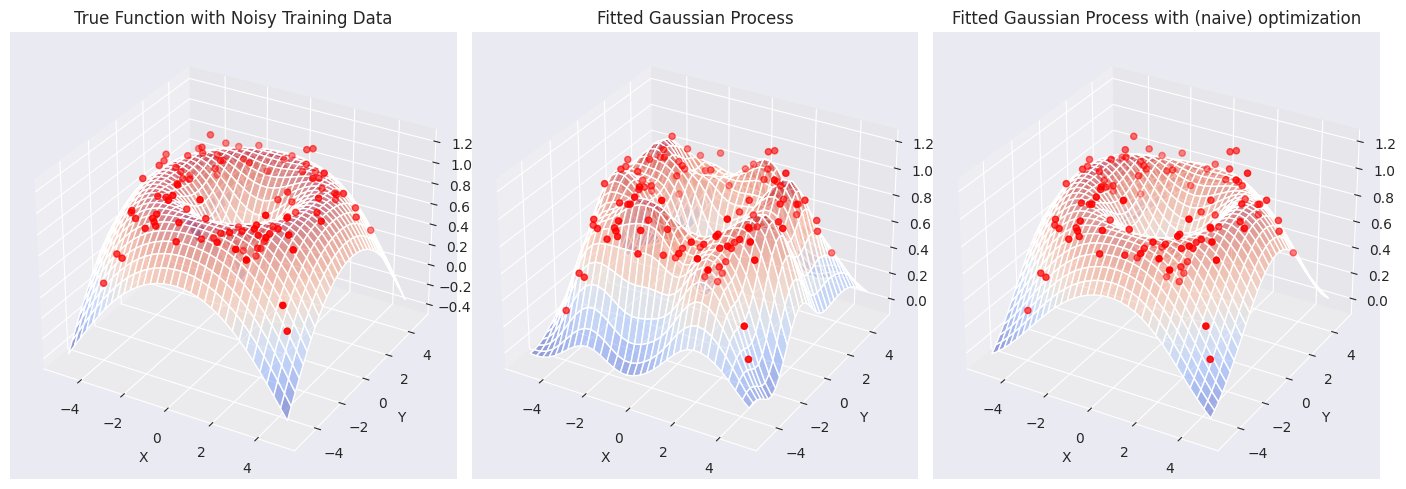

In [139]:
# 3d Plot of a sinusoidal function with 2d gaussian

noise_2D = 0.1
Num_TrainSamples= 100
rx, ry = np.arange(-5, 5, 0.3), np.arange(-5, 5, 0.3)
gx, gy = np.meshgrid(rx, rx)

X_2D = np.c_[gx.ravel(), gy.ravel()]

X_2D_train = np.random.uniform(-4, 4, (Num_TrainSamples, 2))
Y_2D_train = np.sin(0.5 * np.linalg.norm(X_2D_train, axis=1)) + \
             noise_2D * np.random.randn(len(X_2D_train))

# Optimize hyperparameters
initial_guess = [1, 1]
bounds = [(1e-5, None), (1e-5, None)]
res = minimize(objective_function(X_2D_train, Y_2D_train, noise_2D**2), initial_guess, bounds=bounds, method='L-BFGS-B')
sigma_f_opt, l_opt  = res.x

# Without optimization
# Compute posterior mean and covariance with optimized kernel parameters
mu_post, sigma_post = GaussianProcess(
    np.zeros(Num_TrainSamples), X_2D_train, X_2D, Y_2D_train,  var_noise=var_noise
)

# Compute posterior mean and covariance with optimized kernel parameters
mu_post_opt, sigma_post_opt = GaussianProcess(
    np.zeros(Num_TrainSamples), X_2D_train, X_2D, Y_2D_train, theta=[sigma_f_opt, l_opt], var_noise=var_noise
)

# Reshape for plotting
mu_post = mu_post.reshape(gx.shape)
mu_post_opt = mu_post_opt.reshape(gx.shape)
# Plot
fig = plt.figure(figsize=(14, 6))

# Plot 1: True function with training data
ax1 = fig.add_subplot(131, projection='3d')
ax1.plot_surface(gx, gy, np.sin(0.5 * np.linalg.norm(np.c_[gx.ravel(), gy.ravel()], axis=1)).reshape(gx.shape),
                 alpha=0.5, cmap='coolwarm', label='True function')
ax1.scatter(X_2D_train[:, 0], X_2D_train[:, 1], Y_2D_train, c='r', marker='o', label='Training data')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('True Function with Noisy Training Data')

# Plot 2: Fitted Gaussian Process
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(X_2D_train[:, 0], X_2D_train[:, 1], Y_2D_train, c='r', marker='o', label='Training data')
ax2.plot_surface(gx, gy, mu_post, alpha=0.5, cmap='coolwarm', label='GP Prediction')

ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title('Fitted Gaussian Process')

ax3 = fig.add_subplot(133, projection='3d')
ax3.plot_surface(gx, gy, mu_post_opt, alpha=0.5, cmap='coolwarm', label='Optimized GP Prediction')
ax3.scatter(X_2D_train[:, 0], X_2D_train[:, 1], Y_2D_train, c='r', marker='o', label='Training data')
ax3.set_xlabel('X')
ax3.set_ylabel('Y')
ax3.set_zlabel('Z')
ax3.set_title('Fitted Gaussian Process with (naive) optimization')

plt.tight_layout()
plt.show()